<a href="https://colab.research.google.com/github/MKastek/pyspark-notes/blob/main/PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Resource  
https://jacobcelestine.com/knowledge_repo/colab_and_pyspark/#prerequisite  
https://iomete.com/resources/reference/pyspark/pyspark-join  
https://sparkbyexamples.com/pyspark/pyspark-join-explained-with-examples/  
https://luminousmen.com/post/spark-tips-dataframe-api    
https://www.youtube.com/@afaqueahmad7117/playlists  

### Installing PySpark


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark


In [2]:
!ls

sample_data  spark-3.5.1-bin-hadoop3  spark-3.5.1-bin-hadoop3.tgz


In [150]:
import time

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [4]:
import findspark
findspark.init()


import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("PySparkHelloWorld") \
       .master("local[*]") \
       .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

## Spark Session  
Master URL: `master("local[*]")`  
Run Spark locally with as many worker threads as logical cores on your machine.   




In [5]:
num_cores = spark._jsc.sc().getExecutorMemoryStatus().size()
num_cores

1

In [6]:
sc = spark.sparkContext

**Example list of data 1000 numbers**

In [7]:
numbers = list(range(0, 10 ** 3))

**Default Parallelism**

In [8]:
sc.defaultParallelism

2

**Partition**

In [9]:
nums_rdd = sc.parallelize(numbers)

In [10]:
nums_rdd.getNumPartitions()

2

In [11]:
nums_rdd_repartition = nums_rdd.repartition(16)

In [12]:
nums_rdd_repartition.getNumPartitions()

16

In [13]:
%timeit num_rdd_squared = nums_rdd_repartition.map(lambda x: x**2)

189 µs ± 48.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%timeit nums_rdd_repartition.collect()

311 ms ± 40.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Import Data from API into Dataframe

In [15]:
import requests
response = requests.get("https://public-esa.ose.gov.pl/api/v1/smog")
list_json = [school['school'] | school['data'] | {'timestamp': school['timestamp']} for school in response.json()['smog_data']]

**Create DataFrame from parallelized lists of json**

In [16]:
smog_df = spark.createDataFrame(sc.parallelize(list_json))

**Viewing the DataFrame**  
There are a couple of ways to view your dataframe(DF) in PySpark:  
- `df.take(5)` will return a list of five Row objects.  
- `df.collect()` will get all of the data from the entire DataFrame. Be really careful when using it, because if you have a large data set, you can easily crash the driver node.  
- `df.show()` view a dataframe, parametrs (number of rows, truncaiton). Example: `df.show(5, truncate=False)`.  
- `df.limit(5)` will return a new DataFrame by taking the first n rows. As spark is distributed in nature, there is no guarantee that df.limit() will give you the same results each time.


In [17]:
smog_df.show(5, truncate=False)

+-----------------+-----------------+---------+----------+------------------------------------------------------------------------------------+------------------+------------------+---------+------------------+------------------------+-----------------+-------------------+
|city             |humidity_avg     |latitude |longitude |name                                                                                |pm10_avg          |pm25_avg          |post_code|pressure_avg      |street                  |temperature_avg  |timestamp          |
+-----------------+-----------------+---------+----------+------------------------------------------------------------------------------------+------------------+------------------+---------+------------------+------------------------+-----------------+-------------------+
|KRASZEWICE       |82.89            |51.51563 |18.22403  |SZKOŁA PODSTAWOWA IM. MARIANA FALSKIEGO W KRASZEWICACH                              |24.92             |15.3833333333333

In [18]:
smog_df.show(5)

+-----------------+-----------------+---------+----------+--------------------+------------------+------------------+---------+------------------+--------------------+-----------------+-------------------+
|             city|     humidity_avg| latitude| longitude|                name|          pm10_avg|          pm25_avg|post_code|      pressure_avg|              street|  temperature_avg|          timestamp|
+-----------------+-----------------+---------+----------+--------------------+------------------+------------------+---------+------------------+--------------------+-----------------+-------------------+
|       KRASZEWICE|            82.89| 51.51563|  18.22403|SZKOŁA PODSTAWOWA...|             24.92|15.383333333333333|   63-522|1002.2866666666667|         UL. SZKOLNA|7.023333333333333|2024-11-16 17:43:29|
|       WRZĄSOWICE|             72.1| 49.96103|  19.94282|SZKOŁA PODSTAWOWA...|51.833333333333336| 45.76666666666667|   32-040| 978.1666666666666|         UL. SZKOLNA|6.9333333

In [19]:
smog_df.limit(5)

city,humidity_avg,latitude,longitude,name,pm10_avg,pm25_avg,post_code,pressure_avg,street,temperature_avg,timestamp
KRASZEWICE,82.89,51.51563,18.22403,SZKOŁA PODSTAWOWA...,24.92,15.383333333333333,63-522,1002.2866666666667,UL. SZKOLNA,7.023333333333333,2024-11-16 17:43:29
WRZĄSOWICE,72.1,49.96103,19.94282,SZKOŁA PODSTAWOWA...,51.833333333333336,45.76666666666667,32-040,978.1666666666666,UL. SZKOLNA,6.933333333333334,2024-11-16 17:43:29
STRZELCE OPOLSKIE,99.90000000000002,50.503431,18.314889,PUBLICZNA SZKOŁA ...,1.0,0.6066666666666667,47-100,1031.7666666666667,UL. WAWRZYŃCA ŚWI...,6.2,2024-11-16 17:43:29
PSZCZYNA,99.90000000000002,49.965883,18.9457058,ZESPÓŁ SZKÓŁ NR 1...,19.166666666666668,10.86,43-200,995.0,UL. KAZIMIERZA WI...,6.2,2024-11-16 17:43:29
JANKÓW PRZYGODZKI,99.90000000000002,51.596172,17.7889069,ZESPÓŁ SZKÓŁ IM. ...,38.333333333333336,20.346666666666668,63-421,1000.3333333333334,SZKOLNA,6.066666666666666,2024-11-16 17:43:29


In [20]:
smog_df.take(5)

[Row(city='KRASZEWICE', humidity_avg=82.89, latitude='51.51563', longitude='18.22403', name='SZKOŁA PODSTAWOWA IM. MARIANA FALSKIEGO W KRASZEWICACH', pm10_avg=24.92, pm25_avg=15.383333333333333, post_code='63-522', pressure_avg=1002.2866666666667, street='UL. SZKOLNA', temperature_avg=7.023333333333333, timestamp='2024-11-16 17:43:29'),
 Row(city='WRZĄSOWICE', humidity_avg=72.1, latitude='49.96103', longitude='19.94282', name='SZKOŁA PODSTAWOWA WE WRZĄSOWICACH', pm10_avg=51.833333333333336, pm25_avg=45.76666666666667, post_code='32-040', pressure_avg=978.1666666666666, street='UL. SZKOLNA', temperature_avg=6.933333333333334, timestamp='2024-11-16 17:43:29'),
 Row(city='STRZELCE OPOLSKIE', humidity_avg=99.90000000000002, latitude='50.503431', longitude='18.314889', name='PUBLICZNA SZKOŁA PODSTAWOWA NR 2 IM. KAZIMIERZA MALCZEWSKIEGO W STRZELCACH OPOLSKICH', pm10_avg=1.0, pm25_avg=0.6066666666666667, post_code='47-100', pressure_avg=1031.7666666666667, street='UL. WAWRZYŃCA ŚWIERZEGO', te

In [21]:
smog_df.collect()

[Row(city='KRASZEWICE', humidity_avg=82.89, latitude='51.51563', longitude='18.22403', name='SZKOŁA PODSTAWOWA IM. MARIANA FALSKIEGO W KRASZEWICACH', pm10_avg=24.92, pm25_avg=15.383333333333333, post_code='63-522', pressure_avg=1002.2866666666667, street='UL. SZKOLNA', temperature_avg=7.023333333333333, timestamp='2024-11-16 17:43:29'),
 Row(city='WRZĄSOWICE', humidity_avg=72.1, latitude='49.96103', longitude='19.94282', name='SZKOŁA PODSTAWOWA WE WRZĄSOWICACH', pm10_avg=51.833333333333336, pm25_avg=45.76666666666667, post_code='32-040', pressure_avg=978.1666666666666, street='UL. SZKOLNA', temperature_avg=6.933333333333334, timestamp='2024-11-16 17:43:29'),
 Row(city='STRZELCE OPOLSKIE', humidity_avg=99.90000000000002, latitude='50.503431', longitude='18.314889', name='PUBLICZNA SZKOŁA PODSTAWOWA NR 2 IM. KAZIMIERZA MALCZEWSKIEGO W STRZELCACH OPOLSKICH', pm10_avg=1.0, pm25_avg=0.6066666666666667, post_code='47-100', pressure_avg=1031.7666666666667, street='UL. WAWRZYŃCA ŚWIERZEGO', te

**Viewing DataFrame Columns**

In [22]:
smog_df.columns

['city',
 'humidity_avg',
 'latitude',
 'longitude',
 'name',
 'pm10_avg',
 'pm25_avg',
 'post_code',
 'pressure_avg',
 'street',
 'temperature_avg',
 'timestamp']

**Dataframe schema**  
There ate two methods commonly used to view the data types of a dataframe:

In [23]:
smog_df.dtypes

[('city', 'string'),
 ('humidity_avg', 'double'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('name', 'string'),
 ('pm10_avg', 'double'),
 ('pm25_avg', 'double'),
 ('post_code', 'string'),
 ('pressure_avg', 'double'),
 ('street', 'string'),
 ('temperature_avg', 'double'),
 ('timestamp', 'string')]

In [24]:
smog_df.printSchema()

root
 |-- city: string (nullable = true)
 |-- humidity_avg: double (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- name: string (nullable = true)
 |-- pm10_avg: double (nullable = true)
 |-- pm25_avg: double (nullable = true)
 |-- post_code: string (nullable = true)
 |-- pressure_avg: double (nullable = true)
 |-- street: string (nullable = true)
 |-- temperature_avg: double (nullable = true)
 |-- timestamp: string (nullable = true)



**Selecting data**

In [25]:
smog_df.select("*")

city,humidity_avg,latitude,longitude,name,pm10_avg,pm25_avg,post_code,pressure_avg,street,temperature_avg,timestamp
KRASZEWICE,82.89,51.51563,18.22403,SZKOŁA PODSTAWOWA...,24.92,15.383333333333333,63-522,1002.2866666666667,UL. SZKOLNA,7.023333333333333,2024-11-16 17:43:29
WRZĄSOWICE,72.1,49.96103,19.94282,SZKOŁA PODSTAWOWA...,51.833333333333336,45.76666666666667,32-040,978.1666666666666,UL. SZKOLNA,6.933333333333334,2024-11-16 17:43:29
STRZELCE OPOLSKIE,99.90000000000002,50.503431,18.314889,PUBLICZNA SZKOŁA ...,1.0,0.6066666666666667,47-100,1031.7666666666667,UL. WAWRZYŃCA ŚWI...,6.2,2024-11-16 17:43:29
PSZCZYNA,99.90000000000002,49.965883,18.9457058,ZESPÓŁ SZKÓŁ NR 1...,19.166666666666668,10.86,43-200,995.0,UL. KAZIMIERZA WI...,6.2,2024-11-16 17:43:29
JANKÓW PRZYGODZKI,99.90000000000002,51.596172,17.7889069,ZESPÓŁ SZKÓŁ IM. ...,38.333333333333336,20.346666666666668,63-421,1000.3333333333334,SZKOLNA,6.066666666666666,2024-11-16 17:43:29
ĆWIKLICE,79.89999999999999,49.971937,18.989839,SZKOŁA PODSTAWOWA...,22.733333333333334,13.253333333333336,43-229,986.4666666666667,UL. MĘCZENNIKÓW O...,8.0,2024-11-16 17:43:29
STUDZIONKA,91.61666666666667,49.9603559,18.774985,SZKOŁA PODSTAWOWA...,25.590000000000003,14.423333333333334,43-245,989.3433333333332,UL. JORDANA,6.983333333333333,2024-11-16 17:43:29
PIASEK,98.96666666666665,50.00955,18.94634,ZESPÓŁ SZKOLNO-PR...,0.43333333333333335,0.24,43-211,994.2333333333332,SZKOLNA,6.266666666666667,2024-11-16 17:43:29
ŁĄKA,88.0,49.9582444,18.906757,ZESPÓŁ SZKOLNO-PR...,20.953333333333333,12.733333333333334,43-241,994.2966666666666,FITELBERGA,7.489999999999999,2024-11-16 17:43:29
LUBOŃ,99.90000000000002,52.3481,16.8968,SZKOŁA PODSTAWOWA...,16.566666666666666,8.54,62-030,1000.9666666666667,ARMII POZNAŃ,6.266666666666667,2024-11-16 17:43:29


In [26]:
df_of_cities = smog_df.select("city")

**Count of cities**

In [27]:
df_of_cities.count()

1322

In [28]:
df_of_cities.distinct().count()

1007

In [29]:
df_of_cities.groupBy("city").count().orderBy("count", ascending=False)

city,count
POZNAŃ,39
ZABRZE,14
CZĘSTOCHOWA,11
GLIWICE,10
WAŁBRZYCH,10
CHEŁM,8
TYCHY,7
RZESZÓW,7
PSZCZYNA,7
WARSZAWA,7


In [30]:
df_cities_count_5 = df_of_cities.groupBy("city").count().orderBy("count", ascending=False).limit(5)

# UDF (User defined functions)
- PySpark User-Defined Functions (UDFs) help you convert your python code into a scalable version. UDFs are less performanced compare it with pyspark functions.  

- When UDF is running in PySpark, each executor creates a python process. Data will be serialised and deserialised between each executor and python process.

- This leads to lots of performance impact and overhead on spark jobs, making it less efficent. The Python worker consumes huge off-heap memory and so it often leads to memoryOverhead.


**Register a function as UDF**

```python
def squared(x):
  return x * x

spark.udf.register(squaredWithPython, squared)
```  

```python
def squared_typed(x):
  return x * x
spark.udf.register("squaredWithPython", squared_typed, LongType())
```  

```python
from pyspark.sql.functions import udf
@udf("long")
def squared_udf(x):
  return x * x
```


In [31]:
from pyspark.sql.functions import udf
@udf("long")
def squared_udf(x):
  return x * x

df_cities_count_5.select("city", "count", squared_udf("count").alias("count squared"))

city,count,count squared
POZNAŃ,39,1521
ZABRZE,14,196
CZĘSTOCHOWA,11,121
GLIWICE,10,100
WAŁBRZYCH,10,100


In [32]:
from pyspark.sql.types import LongType, IntegerType
from pyspark.sql.functions import udf

def identity(x):
  return x

spark.udf.register("squared_typed", identity)

<function __main__.identity(x)>

In [33]:
df_cities_count_5.select("city", "count", identity("count"))

city,count,count
POZNAŃ,39,39
ZABRZE,14,14
CZĘSTOCHOWA,11,11
GLIWICE,10,10
WAŁBRZYCH,10,10


**List all of udfs**  
In PySpark, once a UDF is registered, you can't directly retrieve or display its code. This is because the UDF is serialized and sent to the executors, but the original Python function used to create it isn't stored within the Spark environment. Therefore, there is no built-in functionality to display the code of a UDF after it's registered.



In [34]:
functions = spark.catalog.listFunctions()
for fun in functions:
  if str(fun.className).startswith("org.apache.spark.sql.UDFRegistration"):
    print(fun)

Function(name='squared_typed', catalog=None, namespace=None, description='N/A.', className='org.apache.spark.sql.UDFRegistration$$Lambda$3558/2071948340', isTemporary=True)


**Round float UDF**

In [35]:
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import udf

def round_float_down(x: float) -> FloatType:
  return round(x,2)

round_float_down_udf = udf(round_float_down, FloatType())

In [36]:
smog_df = smog_df \
.withColumn("humidity_avg", round_float_down_udf("humidity_avg")) \
.withColumn("pm10_avg", round_float_down_udf("pm10_avg")) \
.withColumn("pm25_avg", round_float_down_udf("pm25_avg")) \
.withColumn("pressure_avg", round_float_down_udf("pressure_avg")) \
.withColumn("temperature_avg", round_float_down_udf("temperature_avg"))

smog_df

city,humidity_avg,latitude,longitude,name,pm10_avg,pm25_avg,post_code,pressure_avg,street,temperature_avg,timestamp
KRASZEWICE,82.89,51.51563,18.22403,SZKOŁA PODSTAWOWA...,24.92,15.38,63-522,1002.29,UL. SZKOLNA,7.02,2024-11-16 17:43:29
WRZĄSOWICE,72.1,49.96103,19.94282,SZKOŁA PODSTAWOWA...,51.83,45.77,32-040,978.17,UL. SZKOLNA,6.93,2024-11-16 17:43:29
STRZELCE OPOLSKIE,99.9,50.503431,18.314889,PUBLICZNA SZKOŁA ...,1.0,0.61,47-100,1031.77,UL. WAWRZYŃCA ŚWI...,6.2,2024-11-16 17:43:29
PSZCZYNA,99.9,49.965883,18.9457058,ZESPÓŁ SZKÓŁ NR 1...,19.17,10.86,43-200,995.0,UL. KAZIMIERZA WI...,6.2,2024-11-16 17:43:29
JANKÓW PRZYGODZKI,99.9,51.596172,17.7889069,ZESPÓŁ SZKÓŁ IM. ...,38.33,20.35,63-421,1000.33,SZKOLNA,6.07,2024-11-16 17:43:29
ĆWIKLICE,79.9,49.971937,18.989839,SZKOŁA PODSTAWOWA...,22.73,13.25,43-229,986.47,UL. MĘCZENNIKÓW O...,8.0,2024-11-16 17:43:29
STUDZIONKA,91.62,49.9603559,18.774985,SZKOŁA PODSTAWOWA...,25.59,14.42,43-245,989.34,UL. JORDANA,6.98,2024-11-16 17:43:29
PIASEK,98.97,50.00955,18.94634,ZESPÓŁ SZKOLNO-PR...,0.43,0.24,43-211,994.23,SZKOLNA,6.27,2024-11-16 17:43:29
ŁĄKA,88.0,49.9582444,18.906757,ZESPÓŁ SZKOLNO-PR...,20.95,12.73,43-241,994.3,FITELBERGA,7.49,2024-11-16 17:43:29
LUBOŃ,99.9,52.3481,16.8968,SZKOŁA PODSTAWOWA...,16.57,8.54,62-030,1000.97,ARMII POZNAŃ,6.27,2024-11-16 17:43:29


In [37]:
smog_df.where(smog_df.pm10_avg>45)

city,humidity_avg,latitude,longitude,name,pm10_avg,pm25_avg,post_code,pressure_avg,street,temperature_avg,timestamp
WRZĄSOWICE,72.1,49.96103,19.94282,SZKOŁA PODSTAWOWA...,51.83,45.77,32-040,978.17,UL. SZKOLNA,6.93,2024-11-16 17:43:29
KOBIÓR,99.9,50.060752,18.930274,SZKOŁA PODSTAWOWA...,60.17,36.65,43-210,990.85,UL. TUWIMA,7.67,2024-11-16 17:43:29
LIGOTA POLSKA,99.9,51.239942,17.542356,SZKOŁA PODSTAWOWA...,49.2,33.37,56-400,994.4,LIGOTA POLSKA,6.72,2024-11-16 17:43:29
SMOLNA,99.9,51.158266,17.429288,SZKOŁA PODSTAWOWA...,45.98,28.02,56-400,1000.7,SMOLNA,7.6,2024-11-16 17:43:29
CZERNICA,85.3,51.033897,17.266850,SZKOŁA PODSTAWOWA...,91.57,56.7,55-003,989.67,UL. WROCŁAWSKA,5.67,2024-11-16 17:43:29
ŁOZINA,99.07,51.23388117656271,17.180298682797538,SZKOŁA PODSTAWOWA...,61.47,36.53,55-095,998.8,MILICKA,4.97,2024-11-16 17:43:29
KIEŁCZÓW,93.25,51.1371047031024,17.19065006929958,PRZEDSZKOLE W KIE...,46.55,28.55,55-093,997.1,WROCŁAWSKA,5.6,2024-11-16 17:43:29
PRUDNIK,80.6,50.32109542835716,17.571637628835184,ZESPÓŁ SZKÓŁ W PR...,56.83,36.42,48-200,987.7,UL. DĄBROWSKIEGO,11.0,2024-11-16 17:43:29
KŁODNICA DOLNA,80.19,51.06632652,22.28477957,SZKOŁA PODSTAWOWA...,51.14,40.88,24-224,990.54,NULL,5.91,2024-11-16 17:43:29
CHEŁM,79.92,51.126339150220325,23.479142939944662,SZKOŁA PODSTAWOWA...,61.52,50.33,22-100,990.01,UL. POWSTAŃCÓW WA...,5.77,2024-11-16 17:43:29


In [38]:
smog_df.agg({"pm10_avg":'avg'})

avg(pm10_avg)
32.7768987329302


In [39]:
df_agg = smog_df.groupBy("city").agg({"pm10_avg":'avg',"city":'count'}).orderBy("count(city)",ascending=False)

In [40]:
df_agg.filter(df_agg.city=="POZNAŃ").agg({"city":'count'})

count(city)
1


TempView from dataframe

In [41]:
df_agg.createOrReplaceTempView("df_agg_round")

In [42]:
spark.sql("SELECT * FROM df_agg_round")

city,count(city),avg(pm10_avg)
POZNAŃ,39,10.142820480542305
ZABRZE,14,39.374285561697825
CZĘSTOCHOWA,11,33.58545407381925
GLIWICE,10,18.195000076293944
WAŁBRZYCH,10,29.888000011444092
CHEŁM,8,67.20875144004822
TYCHY,7,24.65142822265625
RZESZÓW,7,29.911428724016464
PSZCZYNA,7,38.65714291163853
WARSZAWA,7,14.555714334760394


# Pyspark joins  

PySpark join syntax:  
```python
df.join(other_df, on=None, how=None)
```

- other_df - right side of the join  
- on - string for the join column name  
- how - `inner` (defualt), `cross`, `outer`, `full`, `full_outer`, `left`, `left_outer`, `right`, `right_outer`, `left_semi`, and `left_anti`


### Partitioning in PySpark  
PySpark dataset are distribted and partitioned across multiple nodes in a cluster.  
Ideally, data with the same join key should be located in the same partition.  
If the two datasets are not already partitioned on the join key, **pyspark may perform a shuffle operation to redistribute the data**, ensuring that rows with the same join key are on the same node. **Shuffling can be expensive operation** - especially for large datasets.

### Join type  
Parameter how determines which rows will be included or excluded in the result.

- **Inner Join**: Returns only the rows with matching keys in both DataFrames.  
- **Left Join**: Returns all rows from the left DataFrame and matching rows from the right DataFrame.  
- **Right Join**: Returns all rows from the right DataFrame and matching rows from the left DataFrame.  
- **Full Outer Join**: Returns all rows from both
DataFrames, including matching and non-matching rows.  
- **Left Semi Join**: Returns all rows from the left DataFrame where there is a match in the right DataFrame.  
- **Left Anti Join**: Returns all rows from the left DataFrame where there is no match in the right DataFrame.  


In [43]:
import pyspark
from pyspark.sql import SparkSession

emp = [(1,"Smith",-1,"2018","10","M",3000), \
    (2,"Rose",1,"2010","20","M",4000), \
    (3,"Williams",1,"2010","10","M",1000), \
    (4,"Jones",2,"2005","10","F",2000), \
    (5,"Brown",2,"2010","40","",-1), \
      (6,"Brown",2,"2010","50","",-1) \
  ] * 10
empColumns = ["emp_id","name","superior_emp_id","year_joined", \
       "emp_dept_id","gender","salary"]

empDF = spark.createDataFrame(data=emp, schema = empColumns)
empDF.printSchema()
empDF.show(truncate=False)

dept = [("Finance",10), \
    ("Marketing",20), \
    ("Sales",30), \
    ("IT",40) \
  ]
deptColumns = ["dept_name","dept_id"]
deptDF = spark.createDataFrame(data=dept, schema = deptColumns)
deptDF.printSchema()
deptDF.show(truncate=False)

root
 |-- emp_id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- superior_emp_id: long (nullable = true)
 |-- year_joined: string (nullable = true)
 |-- emp_dept_id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- salary: long (nullable = true)

+------+--------+---------------+-----------+-----------+------+------+
|emp_id|name    |superior_emp_id|year_joined|emp_dept_id|gender|salary|
+------+--------+---------------+-----------+-----------+------+------+
|1     |Smith   |-1             |2018       |10         |M     |3000  |
|2     |Rose    |1              |2010       |20         |M     |4000  |
|3     |Williams|1              |2010       |10         |M     |1000  |
|4     |Jones   |2              |2005       |10         |F     |2000  |
|5     |Brown   |2              |2010       |40         |      |-1    |
|6     |Brown   |2              |2010       |50         |      |-1    |
|1     |Smith   |-1             |2018       |10         |M     |3000 

## Inner join

In [44]:
%%time
empDF.join(F.broadcast(deptDF),empDF.emp_dept_id ==  deptDF.dept_id,"inner").show(truncate=False)

+------+--------+---------------+-----------+-----------+------+------+---------+-------+
|emp_id|name    |superior_emp_id|year_joined|emp_dept_id|gender|salary|dept_name|dept_id|
+------+--------+---------------+-----------+-----------+------+------+---------+-------+
|1     |Smith   |-1             |2018       |10         |M     |3000  |Finance  |10     |
|2     |Rose    |1              |2010       |20         |M     |4000  |Marketing|20     |
|3     |Williams|1              |2010       |10         |M     |1000  |Finance  |10     |
|4     |Jones   |2              |2005       |10         |F     |2000  |Finance  |10     |
|5     |Brown   |2              |2010       |40         |      |-1    |IT       |40     |
|1     |Smith   |-1             |2018       |10         |M     |3000  |Finance  |10     |
|2     |Rose    |1              |2010       |20         |M     |4000  |Marketing|20     |
|3     |Williams|1              |2010       |10         |M     |1000  |Finance  |10     |
|4     |Jo

In [45]:
%%time
empDF.join(deptDF,empDF.emp_dept_id ==  deptDF.dept_id,"inner").show(truncate=False)

+------+--------+---------------+-----------+-----------+------+------+---------+-------+
|emp_id|name    |superior_emp_id|year_joined|emp_dept_id|gender|salary|dept_name|dept_id|
+------+--------+---------------+-----------+-----------+------+------+---------+-------+
|1     |Smith   |-1             |2018       |10         |M     |3000  |Finance  |10     |
|3     |Williams|1              |2010       |10         |M     |1000  |Finance  |10     |
|4     |Jones   |2              |2005       |10         |F     |2000  |Finance  |10     |
|1     |Smith   |-1             |2018       |10         |M     |3000  |Finance  |10     |
|3     |Williams|1              |2010       |10         |M     |1000  |Finance  |10     |
|4     |Jones   |2              |2005       |10         |F     |2000  |Finance  |10     |
|1     |Smith   |-1             |2018       |10         |M     |3000  |Finance  |10     |
|3     |Williams|1              |2010       |10         |M     |1000  |Finance  |10     |
|4     |Jo

## Data paritiong in Pyspark joins

In [46]:
empDF.rdd.getNumPartitions()

2

In [47]:
def print_partitions(df: DataFrame):
  partitioned_data = df.rdd.glom().collect()

  # Print each partition's data
  for i, partition in enumerate(partitioned_data):
      print(f"Partition {i} contains {len(partition)} records:")
      for row in partition:
          print(row)

In [48]:
print_partitions(empDF)

Partition 0 contains 30 records:
Row(emp_id=1, name='Smith', superior_emp_id=-1, year_joined='2018', emp_dept_id='10', gender='M', salary=3000)
Row(emp_id=2, name='Rose', superior_emp_id=1, year_joined='2010', emp_dept_id='20', gender='M', salary=4000)
Row(emp_id=3, name='Williams', superior_emp_id=1, year_joined='2010', emp_dept_id='10', gender='M', salary=1000)
Row(emp_id=4, name='Jones', superior_emp_id=2, year_joined='2005', emp_dept_id='10', gender='F', salary=2000)
Row(emp_id=5, name='Brown', superior_emp_id=2, year_joined='2010', emp_dept_id='40', gender='', salary=-1)
Row(emp_id=6, name='Brown', superior_emp_id=2, year_joined='2010', emp_dept_id='50', gender='', salary=-1)
Row(emp_id=1, name='Smith', superior_emp_id=-1, year_joined='2018', emp_dept_id='10', gender='M', salary=3000)
Row(emp_id=2, name='Rose', superior_emp_id=1, year_joined='2010', emp_dept_id='20', gender='M', salary=4000)
Row(emp_id=3, name='Williams', superior_emp_id=1, year_joined='2010', emp_dept_id='10', ge

In [49]:
print_partitions(empDF.repartition(4,"emp_dept_id"))

Partition 0 contains 0 records:
Partition 1 contains 0 records:
Partition 2 contains 10 records:
Row(emp_id=2, name='Rose', superior_emp_id=1, year_joined='2010', emp_dept_id='20', gender='M', salary=4000)
Row(emp_id=2, name='Rose', superior_emp_id=1, year_joined='2010', emp_dept_id='20', gender='M', salary=4000)
Row(emp_id=2, name='Rose', superior_emp_id=1, year_joined='2010', emp_dept_id='20', gender='M', salary=4000)
Row(emp_id=2, name='Rose', superior_emp_id=1, year_joined='2010', emp_dept_id='20', gender='M', salary=4000)
Row(emp_id=2, name='Rose', superior_emp_id=1, year_joined='2010', emp_dept_id='20', gender='M', salary=4000)
Row(emp_id=2, name='Rose', superior_emp_id=1, year_joined='2010', emp_dept_id='20', gender='M', salary=4000)
Row(emp_id=2, name='Rose', superior_emp_id=1, year_joined='2010', emp_dept_id='20', gender='M', salary=4000)
Row(emp_id=2, name='Rose', superior_emp_id=1, year_joined='2010', emp_dept_id='20', gender='M', salary=4000)
Row(emp_id=2, name='Rose', supe

In [50]:
print_partitions(empDF.repartitionByRange(4,"emp_dept_id"))

Partition 0 contains 30 records:
Row(emp_id=1, name='Smith', superior_emp_id=-1, year_joined='2018', emp_dept_id='10', gender='M', salary=3000)
Row(emp_id=3, name='Williams', superior_emp_id=1, year_joined='2010', emp_dept_id='10', gender='M', salary=1000)
Row(emp_id=4, name='Jones', superior_emp_id=2, year_joined='2005', emp_dept_id='10', gender='F', salary=2000)
Row(emp_id=1, name='Smith', superior_emp_id=-1, year_joined='2018', emp_dept_id='10', gender='M', salary=3000)
Row(emp_id=3, name='Williams', superior_emp_id=1, year_joined='2010', emp_dept_id='10', gender='M', salary=1000)
Row(emp_id=4, name='Jones', superior_emp_id=2, year_joined='2005', emp_dept_id='10', gender='F', salary=2000)
Row(emp_id=1, name='Smith', superior_emp_id=-1, year_joined='2018', emp_dept_id='10', gender='M', salary=3000)
Row(emp_id=3, name='Williams', superior_emp_id=1, year_joined='2010', emp_dept_id='10', gender='M', salary=1000)
Row(emp_id=4, name='Jones', superior_emp_id=2, year_joined='2005', emp_dept

In [51]:
%%time
empDF.join(deptDF,empDF.emp_dept_id ==  deptDF.dept_id,"inner").show(truncate=False)

+------+--------+---------------+-----------+-----------+------+------+---------+-------+
|emp_id|name    |superior_emp_id|year_joined|emp_dept_id|gender|salary|dept_name|dept_id|
+------+--------+---------------+-----------+-----------+------+------+---------+-------+
|1     |Smith   |-1             |2018       |10         |M     |3000  |Finance  |10     |
|3     |Williams|1              |2010       |10         |M     |1000  |Finance  |10     |
|4     |Jones   |2              |2005       |10         |F     |2000  |Finance  |10     |
|1     |Smith   |-1             |2018       |10         |M     |3000  |Finance  |10     |
|3     |Williams|1              |2010       |10         |M     |1000  |Finance  |10     |
|4     |Jones   |2              |2005       |10         |F     |2000  |Finance  |10     |
|1     |Smith   |-1             |2018       |10         |M     |3000  |Finance  |10     |
|3     |Williams|1              |2010       |10         |M     |1000  |Finance  |10     |
|4     |Jo

In [52]:
from pyspark.sql.functions import broadcast

In [53]:
%%time
empDF.join(broadcast(deptDF),empDF.emp_dept_id ==  deptDF.dept_id,"inner").show(truncate=False)

+------+--------+---------------+-----------+-----------+------+------+---------+-------+
|emp_id|name    |superior_emp_id|year_joined|emp_dept_id|gender|salary|dept_name|dept_id|
+------+--------+---------------+-----------+-----------+------+------+---------+-------+
|1     |Smith   |-1             |2018       |10         |M     |3000  |Finance  |10     |
|2     |Rose    |1              |2010       |20         |M     |4000  |Marketing|20     |
|3     |Williams|1              |2010       |10         |M     |1000  |Finance  |10     |
|4     |Jones   |2              |2005       |10         |F     |2000  |Finance  |10     |
|5     |Brown   |2              |2010       |40         |      |-1    |IT       |40     |
|1     |Smith   |-1             |2018       |10         |M     |3000  |Finance  |10     |
|2     |Rose    |1              |2010       |20         |M     |4000  |Marketing|20     |
|3     |Williams|1              |2010       |10         |M     |1000  |Finance  |10     |
|4     |Jo

In [54]:
empDF.join(deptDF,empDF.emp_dept_id ==  deptDF.dept_id,"inner").explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [cast(emp_dept_id#894 as bigint)], [dept_id#934L], Inner
   :- Sort [cast(emp_dept_id#894 as bigint) ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(cast(emp_dept_id#894 as bigint), 200), ENSURE_REQUIREMENTS, [plan_id=1718]
   :     +- Filter isnotnull(emp_dept_id#894)
   :        +- Scan ExistingRDD[emp_id#890L,name#891,superior_emp_id#892L,year_joined#893,emp_dept_id#894,gender#895,salary#896L]
   +- Sort [dept_id#934L ASC NULLS FIRST], false, 0
      +- Exchange hashpartitioning(dept_id#934L, 200), ENSURE_REQUIREMENTS, [plan_id=1719]
         +- Filter isnotnull(dept_id#934L)
            +- Scan ExistingRDD[dept_name#933,dept_id#934L]




In [55]:
empDF.join(broadcast(deptDF),empDF.emp_dept_id ==  deptDF.dept_id,"inner").explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- BroadcastHashJoin [cast(emp_dept_id#894 as bigint)], [dept_id#934L], Inner, BuildRight, false
   :- Filter isnotnull(emp_dept_id#894)
   :  +- Scan ExistingRDD[emp_id#890L,name#891,superior_emp_id#892L,year_joined#893,emp_dept_id#894,gender#895,salary#896L]
   +- BroadcastExchange HashedRelationBroadcastMode(List(input[1, bigint, false]),false), [plan_id=1743]
      +- Filter isnotnull(dept_id#934L)
         +- Scan ExistingRDD[dept_name#933,dept_id#934L]




In [56]:
joinedDF = empDF.join(broadcast(deptDF),empDF.emp_dept_id ==  deptDF.dept_id,"inner")

## Join strategies  
- Broadcast Hash Join (BHJ)
- Sort Merge Join (SMJ)
- Shuffle Hash Join (SHJ)
- Broadcast Nested Loop Join (BNLJ)
- Cartesian Product Join - Cross Join (CJ)

| Join Strategy            | Typical Use Case                         | Key Factors      | Pros                                           | Cons                                               |
|--------------------------|------------------------------------------|------------------|------------------------------------------------|----------------------------------------------------|
| **Broadcast Hash Join**  | Large table + small table                | Small dataset    | Fast, no shuffle for small-large joins         | Limited by small table size (memory constraints)   |
| **Sort-Merge Join**      | Two large tables                         | Large datasets   | Scalable for large datasets, no need for fitting in memory | High shuffle and sort cost                         |
| **Shuffle Hash Join**    | Two medium-sized tables                  | Medium datasets  | No sorting required, useful for hashable keys  | High memory usage, not efficient for very large data |
| **Broadcast Nested Loop Join** | Non-equi joins, cross joins       | Complex join     | Supports complex join conditions               | Very inefficient, slow for large datasets          |
| **Cartesian Product (Cross Join)** | Explicit cross join           | Cross joins      | Generates all row combinations                 | Very high cost, avoid for large datasets           |

### Choosing the right join strategy  
The Spark Catalyst optimizer will choose a join strategy based on multiple factors, including:

- **Dataset Size**: Small tables favor BroadcastHashJoin; larger tables may lead to SortMergeJoin.  
- **Join Condition**: Equijoins generally allow for hash joins, while non-equijoins may require nested loop joins.  
- **Configuration Settings**: Settings like spark.sql.autoBroadcastJoinThreshold and `spark.sql.join.preferSortMergeJoin` can influence which strategy is chosen.  

### Broadcast Hash Join  
- Large table + small table  
- Small table is broadcasted with use of shared variable, small dataset is than joined with bigger one  


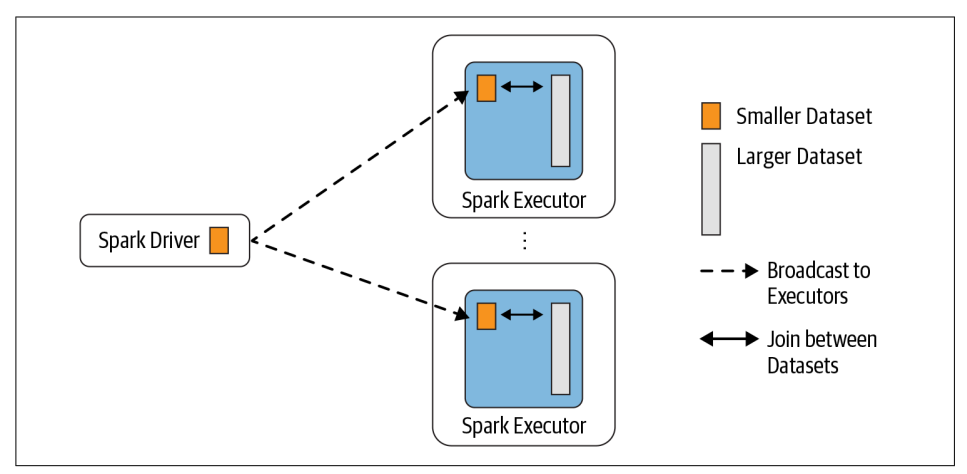

**When to use a broadcast hash join**:  

• When each key within the smaller and larger datasets is hashed to the same partition by Spark  
• When **one dataset is much smaller** than the other (and within the default config
of 10 MB, or more if you have sufficient memory)  
• When you only want to perform an equi-join, to combine two data ets based on
matching unsorted keys  
• When you are **not worried by excessive network bandwidth usage or OOM
errors**, because the smaller data set will be broadcast to all Spark executors  

By default BHJ is used when smaller dataset is less than 10 MB.  
Configuration is changed: `spark.sql.autoBroadcastJoinThreshold`  

BHJ is the simplest and the fastest join within Spark, because there is no shuffling.

In [57]:
joinedDF.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- BroadcastHashJoin [cast(emp_dept_id#894 as bigint)], [dept_id#934L], Inner, BuildRight, false
   :- Filter isnotnull(emp_dept_id#894)
   :  +- Scan ExistingRDD[emp_id#890L,name#891,superior_emp_id#892L,year_joined#893,emp_dept_id#894,gender#895,salary#896L]
   +- BroadcastExchange HashedRelationBroadcastMode(List(input[1, bigint, false]),false), [plan_id=1765]
      +- Filter isnotnull(dept_id#934L)
         +- Scan ExistingRDD[dept_name#933,dept_id#934L]




In [58]:
joinedDF.explain(True)

== Parsed Logical Plan ==
Join Inner, (cast(emp_dept_id#894 as bigint) = dept_id#934L)
:- LogicalRDD [emp_id#890L, name#891, superior_emp_id#892L, year_joined#893, emp_dept_id#894, gender#895, salary#896L], false
+- ResolvedHint (strategy=broadcast)
   +- LogicalRDD [dept_name#933, dept_id#934L], false

== Analyzed Logical Plan ==
emp_id: bigint, name: string, superior_emp_id: bigint, year_joined: string, emp_dept_id: string, gender: string, salary: bigint, dept_name: string, dept_id: bigint
Join Inner, (cast(emp_dept_id#894 as bigint) = dept_id#934L)
:- LogicalRDD [emp_id#890L, name#891, superior_emp_id#892L, year_joined#893, emp_dept_id#894, gender#895, salary#896L], false
+- ResolvedHint (strategy=broadcast)
   +- LogicalRDD [dept_name#933, dept_id#934L], false

== Optimized Logical Plan ==
Join Inner, (cast(emp_dept_id#894 as bigint) = dept_id#934L), rightHint=(strategy=broadcast)
:- Filter isnotnull(emp_dept_id#894)
:  +- LogicalRDD [emp_id#890L, name#891, superior_emp_id#892L, ye

### Shuffle Sort Merge Join

### Shuffle Hashjoin  

- When both tables are large, getting the broadcast join may lead to out-of-memory issues.
- In that case, Shuffle Hash Join can be a better option.  
- These are quite expensive compared to broadcast joins as they involve both shuffling of data and hashing.  


Shuffle Hashjoin happens in two phases:

- Repartitioning on both tables will happen based on the joining keys using hash partitioning, providing 200 partitions (as per the default shuffle partitions config:  default value is 200).
- A hash table is created for the lookup activity, and the join happens based on that.


Currently, most of the Spark systems have made Sort Merge Join their default choice over Shuffle Hash Join because of its consistently better performance compared to Shuffle Hash Joins.

# Shared Variables

## Broadcast Variables  

## Accumulators  




# Dataframe

Spark `DataFrames` are like distributed in-memory tables with named columns and
schemas, where each column has a specific data type  

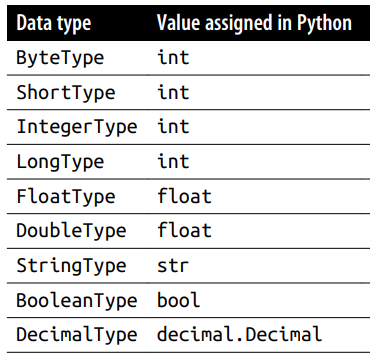  


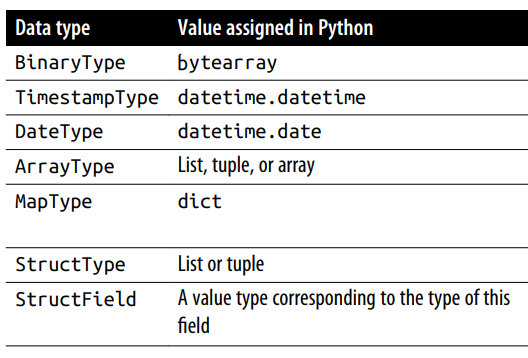  





## Schema  
A schema in Spark defines the column names and associated data types for a DataFrame. Most often, schemas come into play when you are reading structured data
from an external data source.  
  
Defining a schema
up front as opposed to taking a schema-on-read approach offers three benefits:  
- You relieve Spark from the onus of inferring data types.  
- You prevent Spark from creating a separate job just to read a large portion of
your file to ascertain the schema, which for a large data file can be expensive and
time-consuming  
- You can detect errors early if data doesnt match the schema.

## Defining schema

In [59]:
from pyspark.sql.types import *

schema = StructType([StructField("author", StringType(), False),
 StructField("title", StringType(), False),
 StructField("pages", IntegerType(), False)])


In [60]:
schema_ddl = "author STRING, title STRING, pages INT"

In [61]:
schema = StructType([
   StructField("Id", IntegerType(), False),
   StructField("First", StringType(), False),
   StructField("Last", StringType(), False),
   StructField("Url", StringType(), False),
   StructField("Published", StringType(), False),
   StructField("Hits", IntegerType(), False),
   StructField("Campaigns", ArrayType(StringType()), False)])


data = [[1, "Jules", "Damji", "https://tinyurl.1", "1/4/2016", 4535, ["twitter", "LinkedIn"]],
       [2, "Brooke","Wenig","https://tinyurl.2", "5/5/2018", 8908, ["twitter", "LinkedIn"]],
       [3, "Denny", "Lee", "https://tinyurl.3","6/7/2019",7659, ["web", "twitter", "FB", "LinkedIn"]],
       [4, "Tathagata", "Das","https://tinyurl.4", "5/12/2018", 10568, ["twitter", "FB"]],
       [5, "Matei","Zaharia", "https://tinyurl.5", "5/14/2014", 40578, ["web", "twitter", "FB", "LinkedIn"]],
       [6, "Reynold", "Xin", "https://tinyurl.6", "3/2/2015", 25568, ["twitter", "LinkedIn"]]]

blogs_df = spark.createDataFrame(data, schema)


blogs_df

Id,First,Last,Url,Published,Hits,Campaigns
1,Jules,Damji,https://tinyurl.1,1/4/2016,4535,"[twitter, LinkedIn]"
2,Brooke,Wenig,https://tinyurl.2,5/5/2018,8908,"[twitter, LinkedIn]"
3,Denny,Lee,https://tinyurl.3,6/7/2019,7659,"[web, twitter, FB..."
4,Tathagata,Das,https://tinyurl.4,5/12/2018,10568,"[twitter, FB]"
5,Matei,Zaharia,https://tinyurl.5,5/14/2014,40578,"[web, twitter, FB..."
6,Reynold,Xin,https://tinyurl.6,3/2/2015,25568,"[twitter, LinkedIn]"


In [62]:
blogs_df.columns

['Id', 'First', 'Last', 'Url', 'Published', 'Hits', 'Campaigns']

In [63]:
blogs_df["Id"]

Column<'Id'>

In [64]:
from pyspark.sql.functions import *

blogs_df.select(expr("Hits * 2"))

(Hits * 2)
9070
17816
15318
21136
81156
51136


In [65]:
blogs_df = blogs_df.withColumn("Big_Hitters", (expr("Hits > 10000")))
blogs_df

Id,First,Last,Url,Published,Hits,Campaigns,Big_Hitters
1,Jules,Damji,https://tinyurl.1,1/4/2016,4535,"[twitter, LinkedIn]",false
2,Brooke,Wenig,https://tinyurl.2,5/5/2018,8908,"[twitter, LinkedIn]",false
3,Denny,Lee,https://tinyurl.3,6/7/2019,7659,"[web, twitter, FB...",false
4,Tathagata,Das,https://tinyurl.4,5/12/2018,10568,"[twitter, FB]",true
5,Matei,Zaharia,https://tinyurl.5,5/14/2014,40578,"[web, twitter, FB...",true
6,Reynold,Xin,https://tinyurl.6,3/2/2015,25568,"[twitter, LinkedIn]",true


## Selecting data

In [66]:
blogs_df.select(expr("Big_Hitters"))

Big_Hitters
false
false
false
true
true
true


In [67]:
blogs_df.select(col("Big_Hitters"))

Big_Hitters
false
false
false
true
true
true


In [68]:
blogs_df.select("Big_Hitters")

Big_Hitters
false
false
false
true
true
true


## DataFrame Reader

In [69]:
! wget -q https://raw.githubusercontent.com/databricks/LearningSparkV2/refs/heads/master/databricks-datasets/learning-spark-v2/sf-fire/sf-fire-calls.csv

In [70]:
# In Python, define a schema
from pyspark.sql.types import *
# Programmatic way to define a schema
fire_schema = StructType([StructField('CallNumber', IntegerType(), True),
 StructField('UnitID', StringType(), True),
 StructField('IncidentNumber', IntegerType(), True),
 StructField('CallType', StringType(), True),
 StructField('CallDate', StringType(), True),
 StructField('WatchDate', StringType(), True),
 StructField('CallFinalDisposition', StringType(), True),
 StructField('AvailableDtTm', StringType(), True),
 StructField('Address', StringType(), True),
 StructField('City', StringType(), True),
 StructField('Zipcode', IntegerType(), True),
 StructField('Battalion', StringType(), True),
 StructField('StationArea', StringType(), True),
 StructField('Box', StringType(), True),
 StructField('OriginalPriority', StringType(), True),
 StructField('Priority', StringType(), True),
 StructField('FinalPriority', IntegerType(), True),
 StructField('ALSUnit', BooleanType(), True),
 StructField('CallTypeGroup', StringType(), True),
 StructField('NumAlarms', IntegerType(), True),
 StructField('UnitType', StringType(), True),
 StructField('UnitSequenceInCallDispatch', IntegerType(), True),
 StructField('FirePreventionDistrict', StringType(), True),
 StructField('SupervisorDistrict', StringType(), True),
 StructField('Neighborhood', StringType(), True),
 StructField('Location', StringType(), True),
 StructField('RowID', StringType(), True),
 StructField('Delay', FloatType(), True)])
# Use the DataFrameReader interface to read a CSV file
sf_fire_file = "sf-fire-calls.csv"
fire_df = spark.read.csv(sf_fire_file, header=True, schema=fire_schema)

In [71]:
fire_df.show(1)

+----------+------+--------------+--------------+----------+----------+--------------------+--------------------+--------------------+----+-------+---------+-----------+----+----------------+--------+-------------+-------+-------------+---------+--------+--------------------------+----------------------+------------------+---------------+--------------------+-------------+-----+
|CallNumber|UnitID|IncidentNumber|      CallType|  CallDate| WatchDate|CallFinalDisposition|       AvailableDtTm|             Address|City|Zipcode|Battalion|StationArea| Box|OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumAlarms|UnitType|UnitSequenceInCallDispatch|FirePreventionDistrict|SupervisorDistrict|   Neighborhood|            Location|        RowID|Delay|
+----------+------+--------------+--------------+----------+----------+--------------------+--------------------+--------------------+----+-------+---------+-----------+----+----------------+--------+-------------+-------+-------------+

### Narrow transformation  
Narrow transformation does not invlovle shuffle, examples:  
- `filter`row  
- adding new column   
- altering column  
- `select` data

In [72]:
fire_df_narrow_transform = fire_df.filter((col('City') == 'SF') & (col('UnitID') == 'T13')).select("CallType","CallDate","CallType")

### Spark Query Plan   

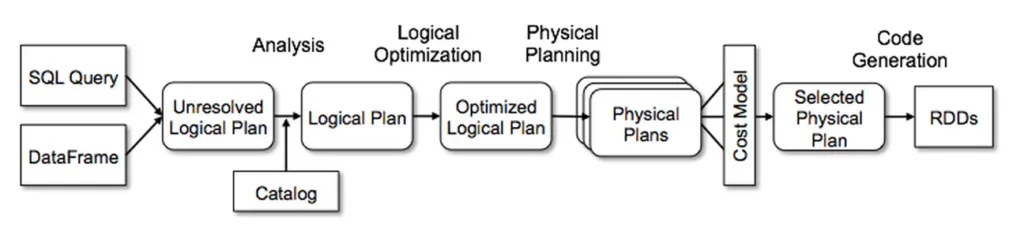


In [73]:
fire_df_narrow_transform.explain(True)

== Parsed Logical Plan ==
'Project ['CallType, 'CallDate, 'CallType]
+- Filter ((City#1421 = SF) AND (UnitID#1413 = T13))
   +- Relation [CallNumber#1412,UnitID#1413,IncidentNumber#1414,CallType#1415,CallDate#1416,WatchDate#1417,CallFinalDisposition#1418,AvailableDtTm#1419,Address#1420,City#1421,Zipcode#1422,Battalion#1423,StationArea#1424,Box#1425,OriginalPriority#1426,Priority#1427,FinalPriority#1428,ALSUnit#1429,CallTypeGroup#1430,NumAlarms#1431,UnitType#1432,UnitSequenceInCallDispatch#1433,FirePreventionDistrict#1434,SupervisorDistrict#1435,... 4 more fields] csv

== Analyzed Logical Plan ==
CallType: string, CallDate: string, CallType: string
Project [CallType#1415, CallDate#1416, CallType#1415]
+- Filter ((City#1421 = SF) AND (UnitID#1413 = T13))
   +- Relation [CallNumber#1412,UnitID#1413,IncidentNumber#1414,CallType#1415,CallDate#1416,WatchDate#1417,CallFinalDisposition#1418,AvailableDtTm#1419,Address#1420,City#1421,Zipcode#1422,Battalion#1423,StationArea#1424,Box#1425,Original

#### Physical plan  
Physical Plan should be read from bottom to top

In [74]:
fire_df_narrow_transform.explain()

== Physical Plan ==
*(1) Project [CallType#1415, CallDate#1416, CallType#1415]
+- *(1) Filter (((isnotnull(City#1421) AND isnotnull(UnitID#1413)) AND (City#1421 = SF)) AND (UnitID#1413 = T13))
   +- FileScan csv [UnitID#1413,CallType#1415,CallDate#1416,City#1421] Batched: false, DataFilters: [isnotnull(City#1421), isnotnull(UnitID#1413), (City#1421 = SF), (UnitID#1413 = T13)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/sf-fire-calls.csv], PartitionFilters: [], PushedFilters: [IsNotNull(City), IsNotNull(UnitID), EqualTo(City,SF), EqualTo(UnitID,T13)], ReadSchema: struct<UnitID:string,CallType:string,CallDate:string,City:string>




### Wide transformation  
Wide transformation involve shuffle, examples:  
- repartitions  
- coalesce  
- joins  
- groupBy   
    - `count`  
    - `countDistinct`  
    - `sum`  


In [75]:
fire_df_narrow_transform.rdd.getNumPartitions()

2

### Round Robin Partitioning  

Data is cyclically and equally distributed among partitions in round-robin partitioning. Regardless of the properties of the data, each split is sequentially assigned the next accessible data item. Implementing round-robin partitioning is simple and can offer a minimal degree of load balancing.   
  
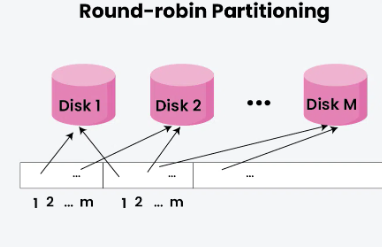

### Adaptative Spark Plan

In [76]:
fire_df_narrow_transform.repartition(10).explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Exchange RoundRobinPartitioning(10), REPARTITION_BY_NUM, [plan_id=1944]
   +- Project [CallType#1415, CallDate#1416, CallType#1415]
      +- Filter (((isnotnull(City#1421) AND isnotnull(UnitID#1413)) AND (City#1421 = SF)) AND (UnitID#1413 = T13))
         +- FileScan csv [UnitID#1413,CallType#1415,CallDate#1416,City#1421] Batched: false, DataFilters: [isnotnull(City#1421), isnotnull(UnitID#1413), (City#1421 = SF), (UnitID#1413 = T13)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/sf-fire-calls.csv], PartitionFilters: [], PushedFilters: [IsNotNull(City), IsNotNull(UnitID), EqualTo(City,SF), EqualTo(UnitID,T13)], ReadSchema: struct<UnitID:string,CallType:string,CallDate:string,City:string>




In [77]:
fire_df_narrow_transform = fire_df_narrow_transform.repartition(10)

In [78]:
fire_df_narrow_transform.rdd.getNumPartitions()

10

In [79]:
fire_df_narrow_transform.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=true
+- == Final Plan ==
   ShuffleQueryStage 0
   +- Exchange RoundRobinPartitioning(10), REPARTITION_BY_NUM, [plan_id=1968]
      +- *(1) Project [CallType#1415, CallDate#1416, CallType#1415]
         +- *(1) Filter (((isnotnull(City#1421) AND isnotnull(UnitID#1413)) AND (City#1421 = SF)) AND (UnitID#1413 = T13))
            +- FileScan csv [UnitID#1413,CallType#1415,CallDate#1416,City#1421] Batched: false, DataFilters: [isnotnull(City#1421), isnotnull(UnitID#1413), (City#1421 = SF), (UnitID#1413 = T13)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/sf-fire-calls.csv], PartitionFilters: [], PushedFilters: [IsNotNull(City), IsNotNull(UnitID), EqualTo(City,SF), EqualTo(UnitID,T13)], ReadSchema: struct<UnitID:string,CallType:string,CallDate:string,City:string>
+- == Initial Plan ==
   Exchange RoundRobinPartitioning(10), REPARTITION_BY_NUM, [plan_id=1956]
   +- Project [CallType#1415, CallDate#1416, CallType#1415]
    

### Coalesce  
In Spark, `coalesce()` is used to reduce the number of partitions in a DataFrame or RDD. It is particularly useful for improving performance when shuffling data is unnecessary or when working with smaller datasets.


**Partition Reduction**:

- `coalesce()` reduces the number of partitions to the specified value.  
- It works by combining adjacent partitions, avoiding a full shuffle of data across the cluster.  

**Efficiency**:

- Unlike `repartition()`,`coalesce()` does not perform a full shuffle. Instead, it merges data within the existing partitions.  
- This makes `coalesce()` more efficient than `repartition()` when the number of partitions is being reduced.  

**Downsizing Only**:

- `coalesce()` is generally used for reducing partitions. While it can technically increase partitions if needed, using `repartition()` is more appropriate for that cas

In [82]:
fire_df_narrow_transform.coalesce(3).explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Coalesce 3
   +- Exchange RoundRobinPartitioning(10), REPARTITION_BY_NUM, [plan_id=2047]
      +- Project [CallType#1415, CallDate#1416, CallType#1415]
         +- Filter (((isnotnull(City#1421) AND isnotnull(UnitID#1413)) AND (City#1421 = SF)) AND (UnitID#1413 = T13))
            +- FileScan csv [UnitID#1413,CallType#1415,CallDate#1416,City#1421] Batched: false, DataFilters: [isnotnull(City#1421), isnotnull(UnitID#1413), (City#1421 = SF), (UnitID#1413 = T13)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/sf-fire-calls.csv], PartitionFilters: [], PushedFilters: [IsNotNull(City), IsNotNull(UnitID), EqualTo(City,SF), EqualTo(UnitID,T13)], ReadSchema: struct<UnitID:string,CallType:string,CallDate:string,City:string>




### groupBy count
groupBy use `HashAggregate` to perform count locally on each worker node (partial count)


In [83]:
fire_df.groupBy("UnitID").count()

UnitID,count
B05,277
M19,253
T13,1157
K1264,13
E02,1960
KM03,335
E44,1205
K1313,4
B01,1951
KM12,439


In [84]:
fire_df.groupBy("UnitID").count().explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[UnitID#1413], functions=[count(1)])
   +- Exchange hashpartitioning(UnitID#1413, 200), ENSURE_REQUIREMENTS, [plan_id=2151]
      +- HashAggregate(keys=[UnitID#1413], functions=[partial_count(1)])
         +- FileScan csv [UnitID#1413] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/sf-fire-calls.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<UnitID:string>




In [85]:
fire_df.groupBy("UnitID").agg(F.sum("Delay"))

UnitID,sum(Delay)
B05,914.4833338558674
M19,945.1166687011719
T13,4636.933342337608
K1264,37.88333332538605
E02,7488.849997788668
KM03,1732.5333260595798
E44,4347.44999961555
K1313,15.850000381469727
B01,6879.299997836351
KM12,1838.299999654293


In [86]:
fire_df.groupBy("UnitID").agg(F.sum("Delay")).explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[UnitID#1413], functions=[sum(Delay#1439)])
   +- Exchange hashpartitioning(UnitID#1413, 200), ENSURE_REQUIREMENTS, [plan_id=2254]
      +- HashAggregate(keys=[UnitID#1413], functions=[partial_sum(Delay#1439)])
         +- FileScan csv [UnitID#1413,Delay#1439] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/sf-fire-calls.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<UnitID:string,Delay:float>




### Push filter   
 FileScan csv has pushed filter (these is part of the logical plan) :  
 `PushedFilters: [IsNotNull(City), IsNotNull(UnitID), EqualTo(City,SF), EqualTo(UnitID,T13)]`

In [87]:
fire_df_narrow_transform.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=true
+- == Final Plan ==
   ShuffleQueryStage 0
   +- Exchange RoundRobinPartitioning(10), REPARTITION_BY_NUM, [plan_id=1968]
      +- *(1) Project [CallType#1415, CallDate#1416, CallType#1415]
         +- *(1) Filter (((isnotnull(City#1421) AND isnotnull(UnitID#1413)) AND (City#1421 = SF)) AND (UnitID#1413 = T13))
            +- FileScan csv [UnitID#1413,CallType#1415,CallDate#1416,City#1421] Batched: false, DataFilters: [isnotnull(City#1421), isnotnull(UnitID#1413), (City#1421 = SF), (UnitID#1413 = T13)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/sf-fire-calls.csv], PartitionFilters: [], PushedFilters: [IsNotNull(City), IsNotNull(UnitID), EqualTo(City,SF), EqualTo(UnitID,T13)], ReadSchema: struct<UnitID:string,CallType:string,CallDate:string,City:string>
+- == Initial Plan ==
   Exchange RoundRobinPartitioning(10), REPARTITION_BY_NUM, [plan_id=1956]
   +- Project [CallType#1415, CallDate#1416, CallType#1415]
    

### Why is a filter step present despite predicate pushdown?  
This is largely due to the way Spark's Catalyst Optimizer works. Specifically, due to two separate stages of the query optimization process: Physical Planning and Logical Planning.

**Logical Planning**  
Catalyst optimizer simplifies the unresolved logical plan (which represents the user's query) by applying various rule-based optimizations. This includes predicate pushdown, projection pushdown where filter conditions and column projections are moved as close to the data source as possible.

**Physical Planning**  
 Physical Planning phase is where the logical plan is translated into one or more physical plans, which can actually be executed on the cluster. This includes operations like file scans, filters, projections, etc.

In this case, during the logical planning phase, the predicate (`F.col("city") == "boston"`) has been pushed down and will be applied during the scan of the Parquet file (`PushedFilters: [IsNotNull(city), EqualTo(city,boston)]`), thus improving performance.

Now, during the physical planning phase, the same filter condition (`+- *(1) Filter (isnotnull(city#73) AND (city#73 = boston))`) is applied again to the data that's been loaded into memory. This is because of the following reasons:

**Guaranteed Correctness**   
It might seem redundant, but remember that not all data sources can handle pushed-down predicates, and not all predicates can be pushed down. Therefore, even if a predicate is pushed down to the data source, Spark still includes the predicate in the physical plan to cover cases where the data source might not have been able to fully apply the predicate. This is Spark's way of making sure the correct data is always returned, no matter the capabilities of the data source.

**No Assumptions**  
Spark's Catalyst optimizer doesn't make assumptions about the data source's ability to handle pushed-down predicates. The optimizer aims to generate plans that return correct results across a wide range of scenarios. Even if the filter is pushed down, Spark does not have the feedback from data source whether the pushdown was successful or not, so it includes the filter operation in the physical plan as well.

It is more of a fail-safe mechanism to ensure data integrity and correctness.

# Solving data skew  
You can solve data skew with two methods:  
- AQE (Adaptive Query Execution)
- Broadcast Joins

In AQE Spark will collect runtime statistics like: number of bytes read and number of partitions.  
AQE:
- Tunning shuffle partitions  
- optimizing joins (SMJ -> BJ)
- optimizing skew join   


https://spark.apache.org/docs/latest/sql-performance-tuning.html#optimizing-skew-join    

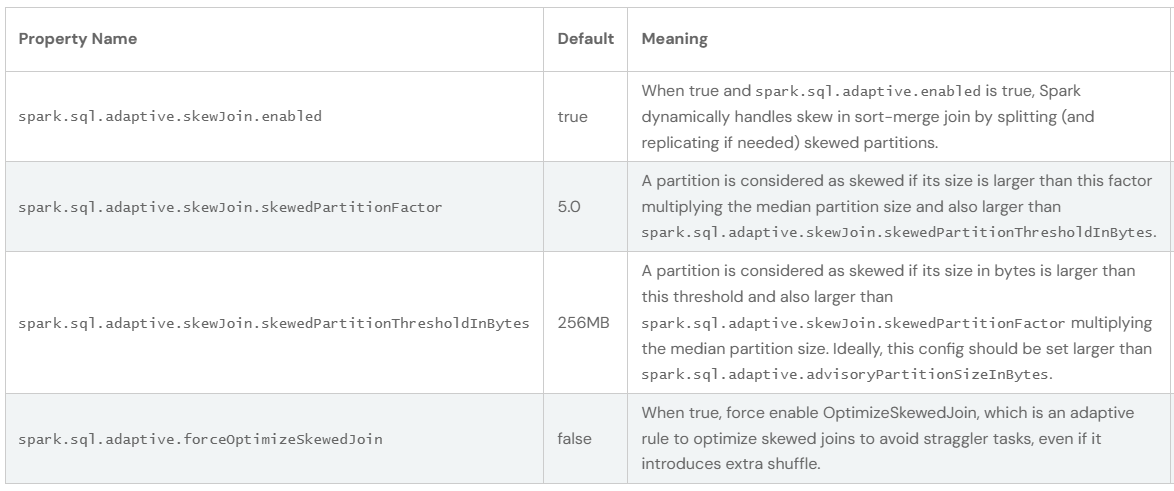

##  Join skews

In [126]:
! apt-get install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.


In [117]:
! ls

customers.parquet  sf-fire-calls.csv	    spark-3.5.1-bin-hadoop3.tgz  transactions.parquet
sample_data	   spark-3.5.1-bin-hadoop3  spark-warehouse


In [134]:
!wget -c https://github.com/afaqueahmad7117/spark-experiments/archive/master.zip | unzip master.zip -d master > /dev/null

replace master/spark-experiments-main/.gitignore? [y]es, [n]o, [A]ll, [N]one, [r]ename: --2024-11-16 18:59:20--  https://github.com/afaqueahmad7117/spark-experiments/archive/master.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/afaqueahmad7117/spark-experiments/zip/main [following]
--2024-11-16 18:59:20--  https://codeload.github.com/afaqueahmad7117/spark-experiments/zip/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [         <=>        ] 702.67M  14.5MB/s    in 50s     

2024-11-16 19:00:10 (14.1 MB/s) - ‘master.zip’ saved [736800130]

 NULL
(EOF or read error, treating as "[N]o

In [135]:
! ls master/spark-experiments-main/data/data_skew

customers.parquet  transactions.parquet


In [141]:
transactions_df = spark.read.parquet("master/spark-experiments-main/data/data_skew/transactions.parquet")
customers_df = spark.read.parquet("master/spark-experiments-main/data/data_skew/customers.parquet")

In [143]:
transactions_df.printSchema()
transactions_df.show(5)

root
 |-- cust_id: string (nullable = true)
 |-- start_date: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- txn_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- expense_type: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- city: string (nullable = true)

+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+-----------+
|   cust_id|start_date|  end_date|         txn_id|      date|year|month|day| expense_type|   amt|       city|
+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+-----------+
|C0YDPQWPBJ|2010-07-01|2018-12-01|TZ5SMKZY9S03OQJ|2018-10-07|2018|   10|  7|Entertainment| 10.42|     boston|
|C0YDPQWPBJ|2010-07-01|2018-12-01|TYIAPPNU066CJ5R|2016-03-27|2016|    3| 27| Motor/Travel| 44.34|   portland|
|C0YDPQWPBJ|2010-07-01|201

In [144]:
customers_df.printSchema()
customers_df.show(5)

root
 |-- cust_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthday: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- city: string (nullable = true)

+----------+-------------+---+------+----------+-----+-----------+
|   cust_id|         name|age|gender|  birthday|  zip|       city|
+----------+-------------+---+------+----------+-----+-----------+
|C007YEYTX9| Aaron Abbott| 34|Female| 7/13/1991|97823|     boston|
|C00B971T1J| Aaron Austin| 37|Female|12/16/2004|30332|    chicago|
|C00WRSJF1Q| Aaron Barnes| 29|Female| 3/11/1977|23451|     denver|
|C01AZWQMF3|Aaron Barrett| 31|  Male|  7/9/1998|46613|los_angeles|
|C01BKUFRHA| Aaron Becker| 54|  Male|11/24/1979|40284|  san_diego|
+----------+-------------+---+------+----------+-----+-----------+
only showing top 5 rows



### Distribution of join key

In [165]:
(
    transactions_df
    .groupBy("cust_id")
    .agg(F.countDistinct("txn_id").alias("ct"))
    .orderBy(F.desc("ct"))
    .show(5, False)
)

+----------+--------+
|cust_id   |ct      |
+----------+--------+
|C0YDPQWPBJ|17539732|
|CBW3FMEAU7|7999    |
|C3KUDEN3KO|7999    |
|C89FCEGPJP|7999    |
|CHNFNR89ZV|7998    |
+----------+--------+
only showing top 5 rows



In [148]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [147]:
transactions_details_df = transactions_df.join(
        customers_df,
        on="cust_id",
        how="inner"
    )


In [151]:
start_time = time.time()
transactions_details_df.count()
print(f"time taken: {time.time() - start_time}")

time taken: 22.8162043094635


## Using Adaptive Query Execution - AQE

In [157]:
spark.conf.set("spark.sql.adaptive.enabled", "true")
spark.conf.set("spark.sql.adaptive.skewedJoin.enabled", "true")
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [158]:
transactions_details_df = transactions_df.join(
        customers_df,
        on="cust_id",
        how="inner"
    )


In [159]:
start_time = time.time()
transactions_details_df.count()
print(f"time taken: {time.time() - start_time}")

time taken: 19.058518886566162


### Using Broadcast Join

In [160]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 10485760)

In [161]:
transactions_details_df = transactions_df.join(
        F.broadcast(customers_df),
        on="cust_id",
        how="inner"
    )


In [163]:
start_time = time.time()
transactions_details_df.count()
print(f"time taken: {time.time() - start_time}")

time taken: 3.469752550125122


## Cache  

## Persist

# RDD

# Dataset